# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we study the effect of the margin in the CosineEmbeddingsLoss function. Since the margin may be closely related to the dimensionality of our embedding space, we set the dimensionalty to 18 in this experiment. Note that we already know from our work in EmbedDim.ipynb that the model performance was significantly deteriorated if we set the dimensionalty less than or equal to 18 when margin is 0.1.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:22<00:00,  4.46it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:49<00:00, 19.90it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  6.88it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:20<00:00, 20.12it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Random Search
We choose different margin values, train the model for 10 epochs, and compare the test loss. In the CosineEmbeddingLoss documentation, $[0.0, 0.5]$ is suggested for margin.

cosine: -0.5 | degree: 120.0
cosine: -0.4 | degree: 113.6
cosine: -0.3 | degree: 107.5
cosine: -0.2 | degree: 101.5
cosine: -0.1 | degree: 95.7
cosine: 0.0 | degree: 90.0
cosine: 0.1 | degree: 84.3
cosine: 0.2 | degree: 78.5
cosine: 0.3 | degree: 72.5
cosine: 0.4 | degree: 66.4
cosine: 0.5 | degree: 60.0
cosine: 0.6 | degree: 53.1
cosine: 0.7 | degree: 45.6
cosine: 0.8 | degree: 36.9
cosine: 0.9 | degree: 25.8
cosine: 1.0 | degree: 0.0


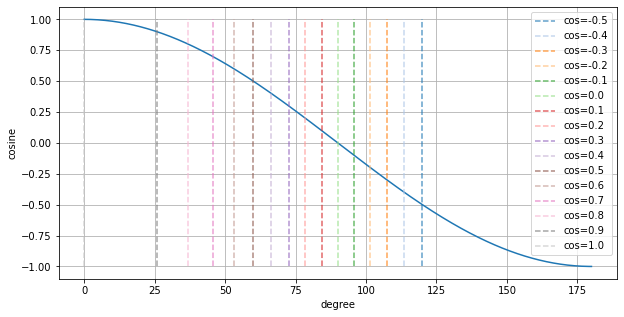

In [ ]:
# Visualize the relationship between cosine and degree.
x = np.linspace(0, np.pi, 1000)
cos = np.cos(x)
degree = x / np.pi * 180

plt.figure(figsize=(10, 5))
plt.plot(degree, cos)
for i in range(-5, 11):
    arcmargin = np.arccos(0.1 * i) / np.pi * 180
    print(f"cosine: {0.1 * i:.1f} | degree: {arcmargin:.1f}")
    plt.plot([arcmargin, arcmargin], [-1, 1], linestyle="dashed", color=plt.cm.tab20(i + 5), alpha=0.7, label=f"cos={0.1 * i:.1f}")
plt.grid()
plt.legend()
plt.xlabel("degree")
plt.ylabel("cosine")
plt.show()

In [ ]:
epochs = 10
batch_size = 128
embed_dim = 18 # We set this to 18 instead of 256 in our base model.
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

margin_pool = [-0.1, 0.0, 0.1, 0.3, 0.5]
train_losses, eval_losses, eval_loss_decomposed, image_MedR = [], [], [], []

for margin in margin_pool:
    print(f"\nMargin = {margin:.1f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=margin, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

    train_loss, eval_loss = [], []
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head, margin=margin)
    _, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
    MedR = utils.getMedR(testloader, sim_mat)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_loss_decomposed.append([pos_loss, neg_loss])
    image_MedR.append(MedR["image"])
    margin_loss = {"train": train_losses, "test": eval_losses, "margin": margin_pool, "MedR": image_MedR}
    with open(f"drive/My Drive/finalproj/margin_loss.pkl", "wb") as f:
        pickle.dump(margin_loss, f)


Margin = -0.1
   Epoch: 5 | Training loss: 0.2201 | Test loss: 0.2201
   Epoch: 10 | Training loss: 0.2201 | Test loss: 0.2201

Margin = 0.0
   Epoch: 5 | Training loss: 0.1639 | Test loss: 0.1783
   Epoch: 10 | Training loss: 0.1095 | Test loss: 0.1594

Margin = 0.1
   Epoch: 5 | Training loss: 0.1581 | Test loss: 0.1660
   Epoch: 10 | Training loss: 0.0969 | Test loss: 0.1398

Margin = 0.3
   Epoch: 5 | Training loss: 0.1138 | Test loss: 0.1262
   Epoch: 10 | Training loss: 0.0601 | Test loss: 0.1035

Margin = 0.5
   Epoch: 5 | Training loss: 0.0617 | Test loss: 0.0817
   Epoch: 10 | Training loss: 0.0364 | Test loss: 0.0771


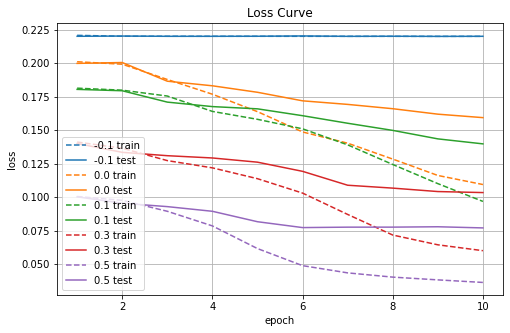

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(margin_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{margin_pool[i]:.1f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{margin_pool[i]:.1f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("margin.png", bbox_inches="tight")
plt.show()

Since the loss functions are different for each setting, the test losses are not comparable. We need other metrics to measure the impact of the margin.

In [ ]:
print(f"Image Retrieval Median Rank")
for i in range(len(margin_pool)):
    print(f"{margin_pool[i]:.1f} | {image_MedR[i]:.0f}")
print(f"Average Loss from Positive and Negative Pairs")
for i in range(len(margin_pool)):
    print(f"{margin_pool[i]:.1f} | positive: {eval_loss_decomposed[i][0]:.4f}, negative: {eval_loss_decomposed[i][1]:.4f}")

Image Retrieval Median Rank
-0.1 | 676
0.0 | 72
0.1 | 62
0.3 | 47
0.5 | 46
Average Loss from Positive and Negative Pairs
-0.1 | positive: 1.1005, negative: 0.0000
0.0 | positive: 0.3935, negative: 0.1009
0.1 | positive: 0.3927, negative: 0.0766
0.3 | positive: 0.3421, negative: 0.0438
0.5 | positive: 0.2886, negative: 0.0242


## 3. Observation
The -0.1 margin results in 676 in MedR. Considering that we have 1,350 images in the test set, this result is nothing but random. With margin 0.1, we already knew that this is a bit too tight for 18 dimensional space. By further relaxing the margin, the MedR dropped to 46. <br>
The -0.1 margin looks giving up optimizing for the positive pairs to avoid the relatively larger loss from negative pairs. In other settings, the average loss from negative pairs is smaller than those from positive pairs, reflecting there are 4 times more negative pairs than positive pairs. By increasing the margin, both losses from positive and negative pairs decrease. The loss from positive pairs of 0.4 means the average angle of positive pairs is 53 degree, while loss of 0.3 implies 45 degree. 

In [ ]:
np.arccos(1-0.2886) / np.pi * 180

44.65106236672462